### Import Libraries and connect to drive

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
# importing required libraries
import numpy as np
import pandas as pd

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt

# importing library for support vector machine classifier
from sklearn.svm import SVC
# importing library for K-neares-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
# importing library for Linear Discriminant Analysis Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# importing library for Quadratic Discriminant Analysis Model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

# representation of model layers
from keras.utils.vis_utils import plot_model
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### CNN_Model_Development

In [ ]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/MajorProjectKDD/train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/MajorProjectKDD/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 3053 images belonging to 2 classes.
Found 749 images belonging to 2 classes.


### Define the image plotting functions

In [ ]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [ ]:
history_this= LossHistory()

### Construct CNN models

#### Model 1: a CNN model by own (baseline)

In [ ]:
model = Sequential()
def cnn_by_own(input_shape,num_class,epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/model_own.h5'):
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['val_accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='accuracy', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )

Epoch 1/5
 6/24 [======>.......................] - ETA: 25s - loss: 0.6856 - accuracy: 0.5554

24/24 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.7940
Epoch 1: accuracy improved from -inf to 0.79397, saving model to /content/drive/MyDrive/MajorProjectKDD/model_own.h5
24/24 [==============================] - 42s 2s/step - loss: 0.3711 - accuracy: 0.7940 - val_loss: 4.1381e-09 - val_accuracy: 1.0000
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 7.1023e-06 - accuracy: 1.0000
Epoch 2: accuracy improved from 0.79397 to 1.00000, saving model to /content/drive/MyDrive/MajorProjectKDD/model_own.h5
24/24 [==============================] - 37s 2s/step - loss: 7.1023e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: accuracy did not improve from 1.00000
24/24 [==============================] - 34s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
24/24 [===============

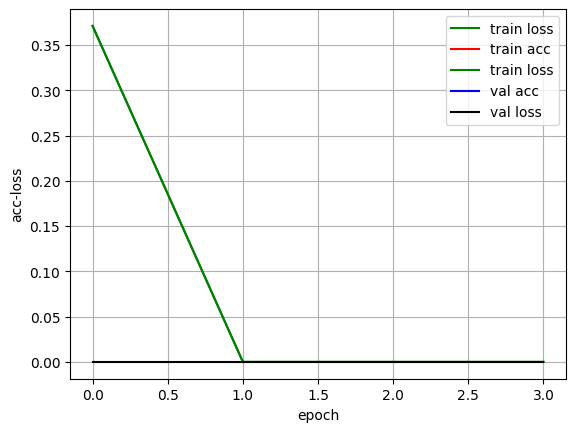

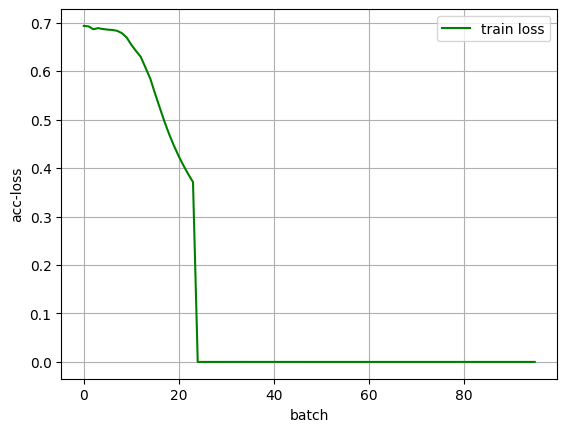

In [ ]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=2,epochs=5)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### For a given image Testing the model

In [ ]:
img_test = image.load_img("/content/drive/MyDrive/MajorProjectKDD/test_224/1/14816.png", target_size=(224, 224))
img_array = image.img_to_array(img_test)
# expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# normalize the image
img_array /= 255.

# make the prediction
prediction = model.predict(img_array)

# print the predicted class label
print(np.argmax(prediction))

1/1 [==============================] - 1s 928ms/step
1


In [ ]:
img_test = image.load_img("/content/drive/MyDrive/MajorProjectKDD/test_224/0/15212.png", target_size=(224, 224))
img_array = image.img_to_array(img_test)
# expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# normalize the image
img_array /= 255.

# make the prediction
prediction = model.predict(img_array)

# print the predicted class label
print(np.argmax(prediction))

1/1 [==============================] - 0s 93ms/step
0


### Xception

In [ ]:
def xception( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9256 
Epoch 1: val_accuracy improved from -inf to 0.97597, saving model to /content/drive/MyDrive/MajorProjectKDD/xception.h5
24/24 [==============================] - 1089s 45s/step - loss: 0.1581 - accuracy: 0.9256 - val_loss: 0.0586 - val_accuracy: 0.9760
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9905
Epoch 2: val_accuracy improved from 0.97597 to 0.99065, saving model to /content/drive/MyDrive/MajorProjectKDD/xception.h5
24/24 [==============================] - 19s 796ms/step - loss: 0.0284 - accuracy: 0.9905 - val_loss: 0.0213 - val_accuracy: 0.9907
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9957
Epoch 3: val_accuracy improved from 0.99065 to 0.99599, saving model to /content/drive/MyDrive/MajorProjectKDD/xception.h5
24/24 [===============

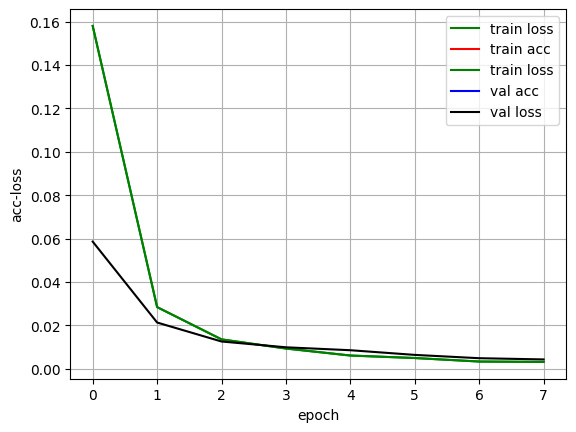

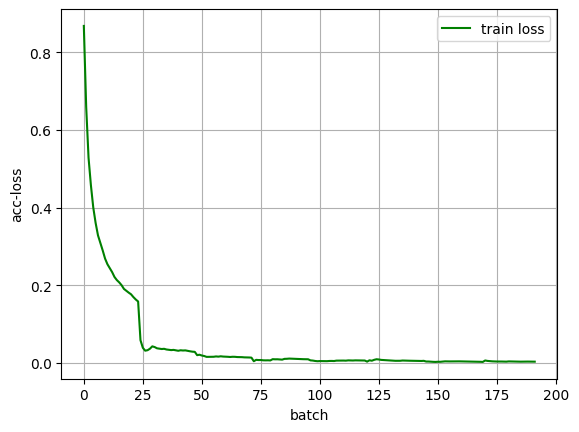

In [ ]:
#default only 50, tf36cnn 99
xception(num_class=2,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 3: VGG16

In [ ]:

def vgg16( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8536
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/MajorProjectKDD/VGG16.h5
24/24 [==============================] - 49s 1s/step - loss: 0.4106 - accuracy: 0.8536 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 2.6744e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
24/24 [==============================] - 19s 761ms/step - loss: 2.6744e-05 - accuracy: 1.0000 - val_loss: 1.5916e-10 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
24/24 [==============================] - 18s 747ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3: earl

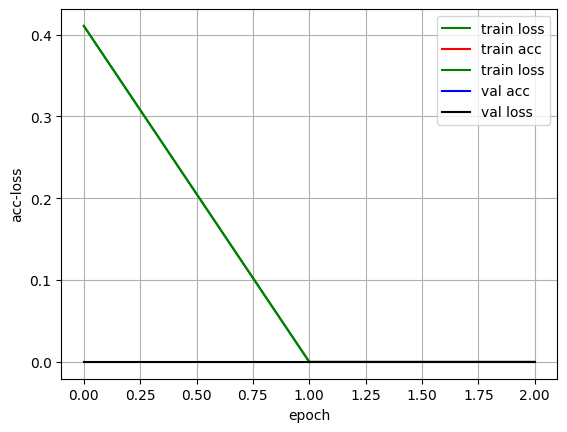

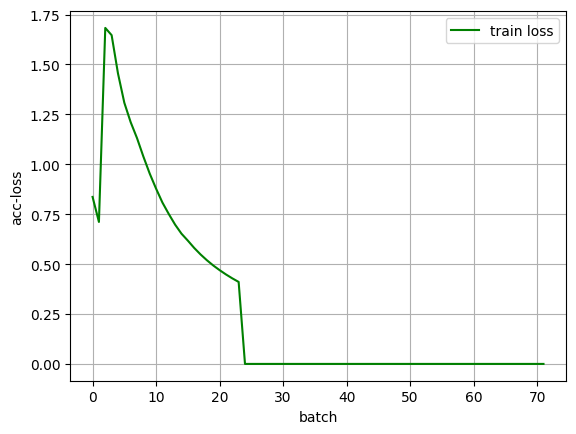

In [ ]:
vgg16(num_class=2,epochs=10)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 4: VGG19

In [ ]:
def vgg19(num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8706
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/MajorProjectKDD/VGG19.h5
24/24 [==============================] - 23s 884ms/step - loss: 0.3342 - accuracy: 0.8706 - val_loss: 3.8027e-06 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 3.3274e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
24/24 [==============================] - 20s 846ms/step - loss: 3.3274e-04 - accuracy: 1.0000 - val_loss: 2.0691e-09 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 6.9422e-08 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
24/24 [==============================] - 20s 825ms/step - loss: 6.9422e-08 - accuracy: 1.0000 - val_loss: 6.9648e-05 - val_accuracy: 1.0000
Epoch 3: e

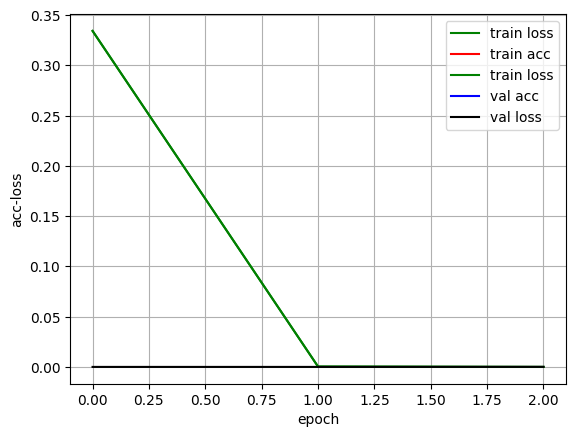

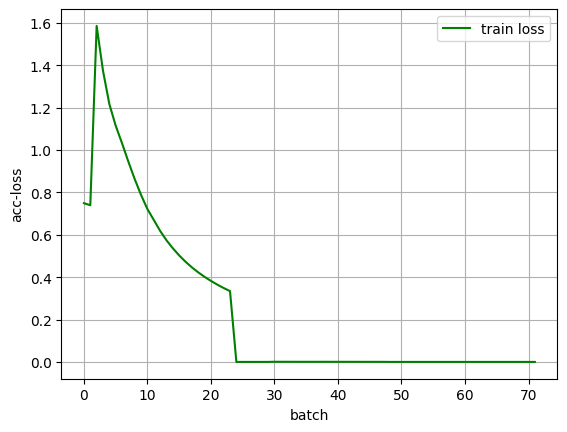

In [ ]:
vgg19(num_class=2,epochs=10)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 5: ResNet

In [ ]:
def resnet( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9705
Epoch 1: val_accuracy improved from -inf to 0.46996, saving model to /content/drive/MyDrive/MajorProjectKDD/resnet.h5
24/24 [==============================] - 39s 1s/step - loss: 0.0575 - accuracy: 0.9705 - val_loss: 6500.5947 - val_accuracy: 0.4700
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9993
Epoch 2: val_accuracy did not improve from 0.46996
24/24 [==============================] - 21s 868ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 2724.9104 - val_accuracy: 0.4700
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 6.4368e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.46996
24/24 [==============================] - 19s 787ms/step - loss: 6.4368e-05 - accuracy: 1.0000 - val_loss: 978.1688 - val_accuracy: 0.4700
Epoch 3: early stopping


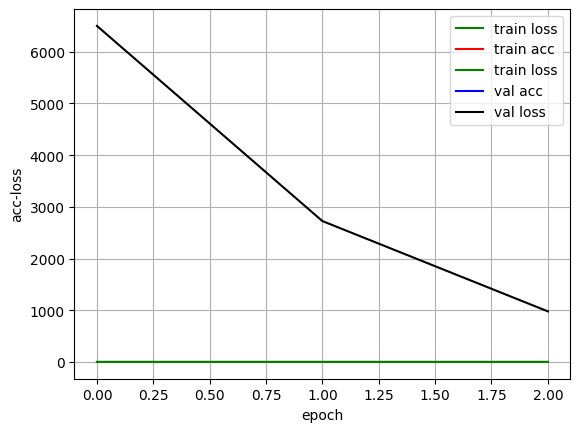

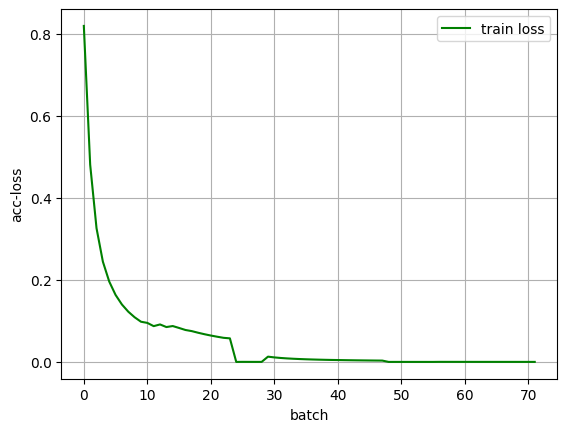

In [ ]:
resnet(num_class=2,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 6: Inception

In [ ]:
def inception( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/10
 6/24 [======>.......................] - ETA: 12s - loss: 0.2427 - accuracy: 0.8698

24/24 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9669
Epoch 1: val_accuracy improved from -inf to 0.53004, saving model to /content/drive/MyDrive/MajorProjectKDD/inception.h5
24/24 [==============================] - 51s 1s/step - loss: 0.0624 - accuracy: 0.9669 - val_loss: 10.3141 - val_accuracy: 0.5300
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 6.5261e-04 - accuracy: 0.9997
Epoch 2: val_accuracy improved from 0.53004 to 0.53405, saving model to /content/drive/MyDrive/MajorProjectKDD/inception.h5
24/24 [==============================] - 26s 1s/step - loss: 6.5261e-04 - accuracy: 0.9997 - val_loss: 3.0941 - val_accuracy: 0.5340
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 3.5110e-05 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.53405 to 0.99332, saving model to /content/drive/MyDrive/MajorProjectKDD/inception.h5
24/24 [==============================] - 25s 1s/step - loss: 3.5110e-05 - accuracy: 1.000

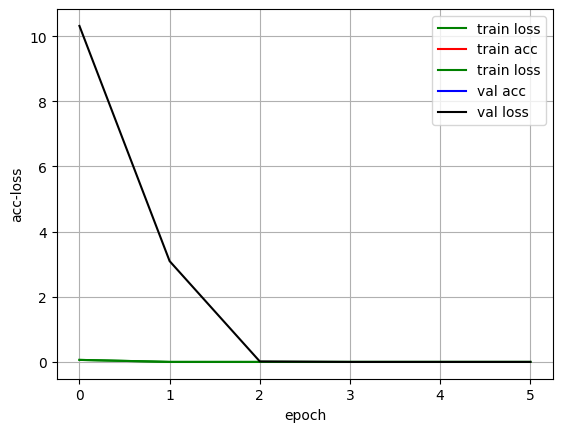

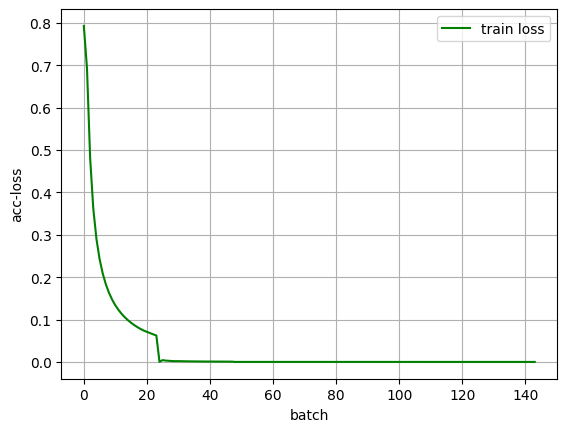

In [ ]:
inception(num_class=2,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 7: InceptionResnet

In [ ]:
def inceptionresnet( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9607
Epoch 1: val_accuracy improved from -inf to 0.46996, saving model to /content/drive/MyDrive/MajorProjectKDD/inceptionresnet.h5
24/24 [==============================] - 56s 2s/step - loss: 0.0687 - accuracy: 0.9607 - val_loss: 146.1097 - val_accuracy: 0.4700
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.0067e-04 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.46996 to 0.52336, saving model to /content/drive/MyDrive/MajorProjectKDD/inceptionresnet.h5
24/24 [==============================] - 37s 2s/step - loss: 1.0067e-04 - accuracy: 1.0000 - val_loss: 597.3834 - val_accuracy: 0.5234
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 2.1254e-05 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.52336 to 0.57009, saving model to /content/drive/MyDrive/MajorProjectKDD/inceptionresnet.h5
24/24 [==============================] - 37s 2s/step - lo

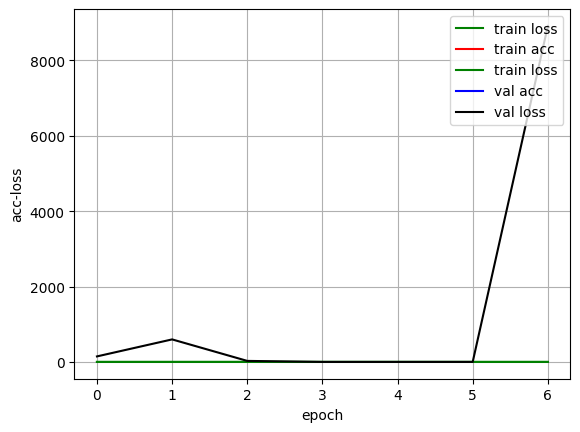

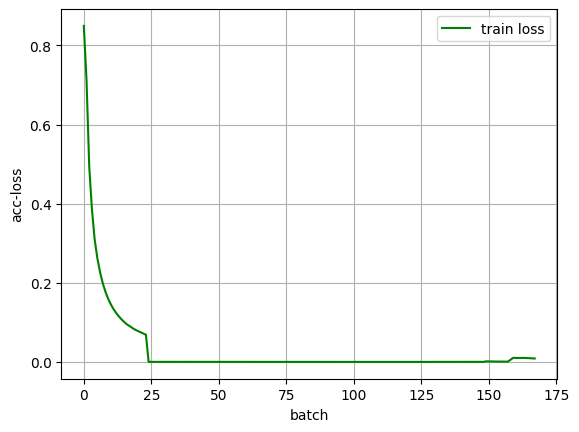

In [18]:
inceptionresnet(num_class=2,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()